# B-Value estimates from Maximum Likelihood

Here we implement the maximum likelihood method from Tinti and Mulargia [1987]. We will compute the distribution of b-values from the stochastic event set and compare with the Comcat catalog. We will filter both the stochastic event sets and the catalog above Mw 3.95.

In [1]:
import time
import os
import pandas as pd
import numpy as np
import scipy.stats as stats
from csep.utils.plotting import plot_mfd
import csep
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
def bval_ml_est(mws, dmw):
    
    # compute the p term from eq 3.10 in marzocchi and sandri [2003]
    def p():
        top = dmw
        # assuming that the magnitudes are truncated above Mc (ask about this).
        bottom = np.mean(mws) - np.min(mws)
        return 1 + top / bottom
    
    bottom = np.log(10) * dmw
    return 1.0 / bottom * np.log(p())

def bval_err_est(mws, dmw):
    
    # compute the p term from eq 3.10 in marzocchi and sandri [2003]
    def p():
        top = dmw
        # assuming that the magnitudes are truncated above Mc (ask about this).
        bottom = np.mean(mws) - np.min(mws)
        return 1 + top / bottom

    top = 1 - p()
    bottom = np.log(10)*dmw*np.sqrt(len(mws)*p())
    return top / bottom

def discretize(data, bin_edges):
    """
    returns array with len(bin_edges) consisting of the discretized values from each bin. 
    instead of returning the counts of each bin, this will return an array with values 
    modified such that any value within bin_edges[0] <= x_new < bin_edges[1] ==> x_new.
    """
    n = data.shape[0]
    idx = digitize(data, bins=bin_edges)
    x_new = bin_edges[idx]
    return x_new

In [3]:
# Comcat Synthetics
epoch_time = 709732655000
duration_in_years = 1.0
t0 = time.time()
comcat = csep.load_catalog(type='comcat', format='native',
                        start_epoch=epoch_time, duration_in_years=1.0,
                        min_magnitude=2.5, 
                        min_latitude=31.50, max_latitude=43.00,
                        min_longitude=-125.40, max_longitude=-113.10,
                    name='Comcat').filter('magnitude > 3.95')
t1 = time.time()

# Statements about Comcat Downloads
print("Fetched Comcat catalog in {} seconds.\n".format(t1-t0))
print("Downloaded Comcat Catalog with following parameters")
print("Start Date: {}\nEnd Date: {}".format(str(comcat.start_time), str(comcat.end_time)))
print("Min Latitude: {} and Max Latitude: {}".format(comcat.min_latitude, comcat.max_latitude))
print("Min Longitude: {} and Max Longitude: {}".format(comcat.min_longitude, comcat.max_longitude))
print("Min Magnitude: {} and Max Magnitude: {}\n".format(comcat.min_magnitude, comcat.max_magnitude))

Fetched Comcat catalog in 6.098243951797485 seconds.

Downloaded Comcat Catalog with following parameters
Start Date: 1992-06-28 12:00:59.904000+00:00
End Date: 1993-05-31 08:55:11.616000+00:00
Min Latitude: 32.242000579833984 and Max Latitude: 41.52033233642578
Min Longitude: -124.40650177001953 and Max Longitude: -113.19066619873047
Min Magnitude: 3.9600000381469727 and Max Magnitude: 6.300000190734863



In [4]:
# read in ucerf3 simulations
project_root = '/Users/wsavran/Projects/CSEP2/u3etas_simulations/landers_experiment'
filename = os.path.join(project_root, '10-23-2018_landers-pt1/results_complete.bin')
filename_nofaults = os.path.join(project_root, '10-31-2018_landers-nofaults-pt1/results_complete.bin')
u3catalogs = []
for cat in csep.load_stochastic_event_set(filename=filename, format='native', type='ucerf3', name='UCERF3-ETAS'):
    u3catalogs.append(cat.filter('magnitude > 3.95'))

-0.0620467887229116


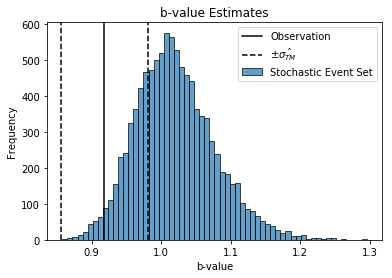

In [36]:
dmw = 0.1
b_vals = []

# get b-values from stochastic event set
for cat in u3catalogs:
    global_max = max([max(cat.get_magnitudes()), max(comcat.get_magnitudes())])
    mws = arange(3.95, global_max+2*dmw, dmw)
    cat_mws = discretize(cat.get_magnitudes(), mws)
    b_est = bval_ml_est(cat_mws, dmw)
    b_vals.append(b_est)
b_vals = np.array(b_vals)

# get b-value for comcat catalog
com_mws = discretize(comcat.get_magnitudes(), mws)
com_bval = bval_ml_est(com_mws, dmw)
com_bval_err = bval_err_est(com_mws, dmw)
print(com_bval_err)

# plot b-value estimates
fig = hist(b_vals, bins = 60, edgecolor='black', alpha=0.7, label='Stochastic Event Set')
axvline(x=com_bval, color='black', linestyle='-', label='Observation')
axvline(x=com_bval-com_bval_err, color='black', linestyle='--', label='$\pm\hat{\sigma_{TM}}$')
axvline(x=com_bval+com_bval_err, color='black', linestyle='--')
xlabel('b-value')
ylabel('Frequency')
title('b-value Estimates')
legend(loc='upper right')

## Verifying computation of $a$ from Michael [2014]

$log(N(m)) = a - bM$ <br>
$ a = log(N(m)/T) + bM $

From Table 2 in Michael [2014], <br>
$T$: 1900 $-$ 2009 <br>
$M_c:$ 7.7 <br> 
$N^{\prime}:$ 100 <br> 
$b$ = 1.59 $\pm$ 0.13

In [50]:
Np = 100
b = 1.59
Mc = 7.7
T = 2009-1900
sigma = 0.13

def a_val(N, M, b, T):
    return np.log10(N/T) + M*b

a = a_val(Np, Mc, b, T)
print(a)

def a_err(a, b, sigma):
    return a*sigma/b

print(a_err(a, b, sigma))

12.205573502059377
0.9979399718664899


In [46]:
Np = 635
b = 1.07
Mc = 7.0
T = 2009-1918
sigma = 0.03

def a_val(N, M, b, T):
    return np.log10(N/T) + M*b

a = a_val(Np, Mc, b, T)
print(a)

def a_err(a, b, sigma):
    return sigma/b*a

print(a_err(a, b, sigma))

8.333732332970882
0.23365604671880974


In [51]:
Np = 810
b = 1.05
Mc = 6.8
T = 2009-1940
sigma = 0.03

def a_val(N, M, b, T):
    return np.log10(N/T) + M*b

a = a_val(Np, Mc, b, T)
print(a)

def a_err(a, b, sigma):
    return sigma/b*a

print(a_err(a, b, sigma))

8.209635928141394
0.23456102651832553
